In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, getpass

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'finger_individuation')
dataDir = os.path.join(baseDir, 'data')
analysisDir = os.path.join(baseDir, 'analysis')


# visualize trial

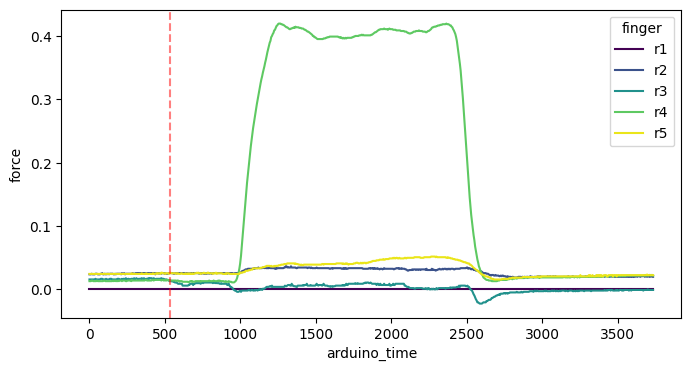

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Fixed blue shades per finger (f1 darkest → f5 lightest)
finger_colors = {
    1: '#440154',
    2: '#3b528b',
    3: '#21918c',
    4: '#5ec962',
    5: '#eae51a',
}
r_palette = {f'r{i}': finger_colors[i] for i in range(1,6)}

data = pd.read_csv(os.path.join(dataDir, 's101_01_20250829_135546.csv'))
D = pd.read_csv(os.path.join(dataDir, 's101_01_trials_20250829_135547.csv'))
TN = 120

# get the trial info:
force_center = D.force_center[D.TN==TN].values[0]
force_range = D.force_range[D.TN==TN].values[0]

rows = (data.TN == TN)
data_tr = data[rows].reset_index()
force_offset = [0., 0.04655022, 0.05359694, 0.06118613, 0.09567314]
data_tr[['r1', 'r2', 'r3', 'r4', 'r5']] = data_tr[['r1', 'r2', 'r3', 'r4', 'r5']]/1024
data_tr[['r1', 'r2', 'r3', 'r4', 'r5']] = data_tr[['r1', 'r2', 'r3', 'r4', 'r5']] - force_offset
long = data_tr.melt(id_vars=['arduino_time','state'],
                    value_vars=['r1', 'r2', 'r3', 'r4', 'r5'],
                    var_name='finger', value_name='force')
long['arduino_time'] = long['arduino_time'] - long['arduino_time'].values[0]
go_cue = np.where(long['state'] == "EXECUTION")[0][0]
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(data=long, x='arduino_time', y='force', hue='finger', ax=ax, dashes=False, palette=r_palette)
ax.axvline(x=long['arduino_time'].values[go_cue], color='r', linestyle='--', alpha=0.5)



# subject df

In [25]:
data = pd.read_csv(os.path.join(dataDir, 's101_01_20250829_135546.csv'))
D = pd.read_csv(os.path.join(dataDir, 's101_01_trials_20250829_135547.csv'))
sn = D.subject_id.values[0]
trials = D.TN
ts = 5 # sampling time in ms
hold_time = D.hold_time.values[0]

df = {'sn':[], 'BN':[], 'TN':[], 'instructed_hand':[], 'instructed_finger':[], 'force_center':[], 'success':[],
      'r1':[], 'r2':[], 'r3':[], 'r4':[], 'r5':[], 'l1':[], 'l2':[], 'l3':[], 'l4':[], 'l5':[],
      'Br1':[], 'Br2':[], 'Br3':[], 'Br4':[], 'Br5':[], 'Bl1':[], 'Bl2':[], 'Bl3':[], 'Bl4':[], 'Bl5':[],
      'MD_p':[], 'MD_r1':[], 'MD_r2':[], 'MD_r3':[], 'MD_r4':[], 'MD_r5':[], 'MD_l1':[], 'MD_l2':[], 'MD_l3':[], 'MD_l4':[], 'MD_l5':[]}

for i, tr in enumerate(trials):
    BN = np.int64(D.BN.values[i])
    TN = np.int64(tr)
    instructed_finger = np.int64(D.finger.values[i])
    instructed_hand = np.int64(D.hand.values[i])
    force_center = D.force_center.values[i]
    success = D.hold_success.values[i]
    # get force data:
    rows = data[data.TN == tr].reset_index()
      
    go_cue = np.where(rows['state'] == "EXECUTION")[0][0]
    exec_finish = np.where(rows['state'] == "EXECUTION")[0][-1]
    # baseline force: 100ms before go-cue to 50ms after
    BF = rows[['r1', 'r2', 'r3', 'r4', 'r5', 'l1', 'l2', 'l3', 'l4', 'l5']].iloc[go_cue-20:go_cue+5].mean().values/1023
    # average force: during the hold period
    AVG = rows[['r1', 'r2', 'r3', 'r4', 'r5', 'l1', 'l2', 'l3', 'l4', 'l5']].iloc[exec_finish-int(hold_time//ts):exec_finish+1].mean().values/1023

    # mean deviation for each finger, from go-cue to exec_finish, compute the deviation of force from baseline.
    #                 Then get the average RMS, 1/T sqrt(sum(F_t - BF)^2)
    forces = rows[['r1', 'r2', 'r3', 'r4', 'r5', 'l1', 'l2', 'l3', 'l4', 'l5']].iloc[go_cue:exec_finish+1].values/1023
    forces = forces - BF
    MD = np.sqrt(np.mean((forces)**2, axis=0))
    MD[instructed_finger-1 + 5*(instructed_hand==0)] = -1

    # mean deviation of all passive fingers: 1/T sum_0_T(sum_passivefingers((Ftj - BFj)^2)):
    if instructed_hand == 1: # right hand:
        # forces other than the instructed finger:
        forces[:, instructed_finger-1] = np.nan
        fingers_rms = np.sqrt(np.nanmean((forces[:,0:5])**2, axis=1))
        MD_p = np.mean(fingers_rms)
    elif instructed_finger == 0: # left hand
        forces[:, instructed_finger-1 + 5] = np.nan
        fingers_rms = np.sqrt(np.nanmean((forces[:,5:10])**2, axis=1))
        MD_p = np.mean(fingers_rms)

    # add to df:
    df['sn'].append(sn)
    df['BN'].append(BN)
    df['TN'].append(TN)
    df['instructed_hand'].append(instructed_hand)
    df['instructed_finger'].append(instructed_finger)
    df['force_center'].append(force_center)
    df['success'].append(success)
    for j in range(5):
        df['r'+str(j+1)].append(AVG[j])
        df['l'+str(j+1)].append(AVG[j+5])
        df['Br'+str(j+1)].append(BF[j])
        df['Bl'+str(j+1)].append(BF[j+5])
        df['MD_r'+str(j+1)].append(MD[j])
        df['MD_l'+str(j+1)].append(MD[j+5])
    df['MD_p'].append(MD_p)
    
df = pd.DataFrame(df)
df.to_csv(os.path.join(analysisDir, 's101.csv'), index=False)



# analysis

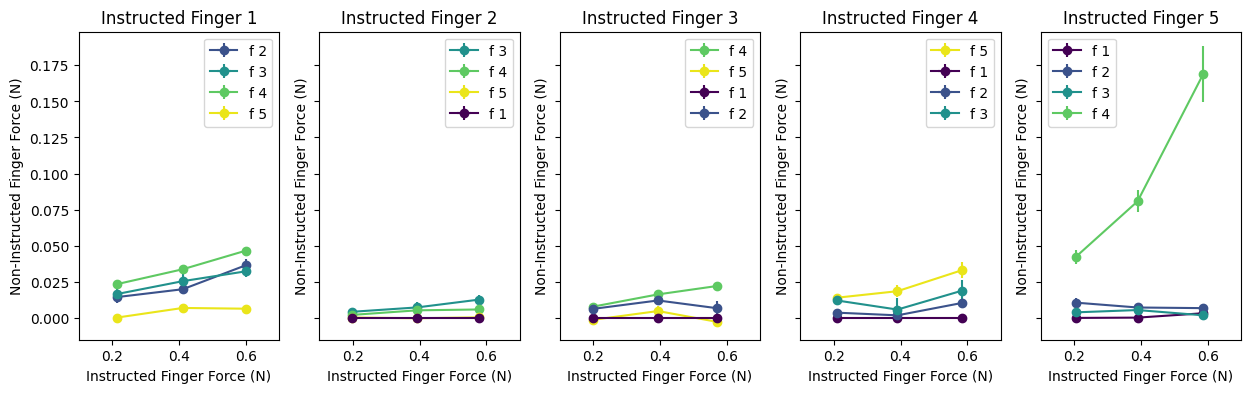

In [31]:
df = pd.read_csv(os.path.join(analysisDir, 's101.csv'))
force_centers = [0.2, 0.4, 0.6]

# Fixed blue shades per finger (f1 darkest → f5 lightest)
finger_colors = {
    1: '#440154',
    2: '#3b528b',
    3: '#21918c',
    4: '#5ec962',
    5: '#eae51a',
}

# non-instructed finger avg_force vs instructed finger avg_force
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,4), sharey=True)
for f in range(1, 6):
    x = []
    xerr = []
    y1 = []
    y1err = []
    y2 = []
    y2err = []
    y3 = []
    y3err = []
    y4 = []
    y4err = []
    for fc in force_centers:
        rows = (df['instructed_hand']==1) & (df['instructed_finger']==f) & (df['force_center']==fc) & (df['success']==1)
        avg_forces = df[rows][['r1', 'r2', 'r3', 'r4', 'r5']].values
        baseline = df[rows][['Br1', 'Br2', 'Br3', 'Br4', 'Br5']].values

        force = avg_forces - baseline
        
        x_mean = np.mean(force[:,f-1])
        x_err = np.std(force[:,f-1]) / np.sqrt(force.shape[0])
        x.append(x_mean)
        xerr.append(x_err)

        y1_mean = np.mean(force[:,(f)%5])
        y1_err = np.std(force[:,(f)%5]) / np.sqrt(force.shape[0])
        y2_mean = np.mean(force[:,(f+1)%5])
        y2_err = np.std(force[:,(f+1)%5]) / np.sqrt(force.shape[0])
        y3_mean = np.mean(force[:,(f+2)%5])
        y3_err = np.std(force[:,(f+2)%5]) / np.sqrt(force.shape[0])
        y4_mean = np.mean(force[:,(f+3)%5])
        y4_err = np.std(force[:,(f+3)%5]) / np.sqrt(force.shape[0])

        y1.append(y1_mean)
        y2.append(y2_mean)
        y3.append(y3_mean)
        y4.append(y4_mean)

        y1err.append(y1_err)
        y2err.append(y2_err)
        y3err.append(y3_err)
        y4err.append(y4_err)
    
    f_y1 = (f)%5 + 1
    f_y2 = (f+1)%5 + 1
    f_y3 = (f+2)%5 + 1
    f_y4 = (f+3)%5 + 1
    ax[f-1].errorbar(x, y1, xerr=xerr, yerr=y1err, fmt='o-', color=finger_colors[f_y1], label='f '+str(f_y1))
    ax[f-1].errorbar(x, y2, xerr=xerr, yerr=y2err, fmt='o-', color=finger_colors[f_y2], label='f '+str(f_y2))
    ax[f-1].errorbar(x, y3, xerr=xerr, yerr=y3err, fmt='o-', color=finger_colors[f_y3], label='f '+str(f_y3))
    ax[f-1].errorbar(x, y4, xerr=xerr, yerr=y4err, fmt='o-', color=finger_colors[f_y4], label='f '+str(f_y4))
    ax[f-1].set_title('Instructed Finger '+str(f))
    ax[f-1].set_xlabel('Instructed Finger Force (N)')
    ax[f-1].set_ylabel('Non-Instructed Finger Force (N)')
    ax[f-1].set_xlim([0.1, 0.7])
    # legend:
    ax[f-1].legend()
plt.show()


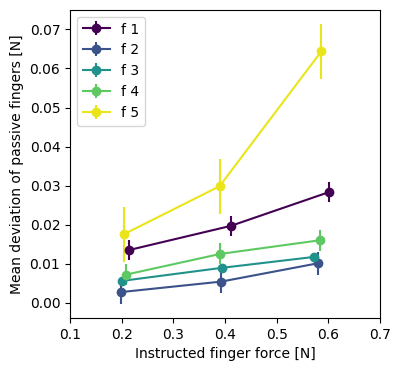

In [38]:
df = pd.read_csv(os.path.join(analysisDir, 's101.csv'))
force_centers = [0.2, 0.4, 0.6]

# Fixed blue shades per finger (f1 darkest → f5 lightest)
finger_colors = {
    1: '#440154',
    2: '#3b528b',
    3: '#21918c',
    4: '#5ec962',
    5: '#eae51a',
}

# non-instructed finger avg_force vs instructed finger avg_force
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
for f in range(1, 6):
    x = {'1': [],
         '2': [],
         '3': [],
         '4': [],
         '5': []}
    y = {'1': [],
         '2': [],
         '3': [],
         '4': [],
         '5': []}
    xerr = {'1': [],
            '2': [],
            '3': [],
            '4': [],
            '5': []}
    yerr = {'1': [],
            '2': [],
            '3': [],
            '4': [],
            '5': []}
    for fc in force_centers:
        rows = (df['instructed_hand']==1) & (df['instructed_finger']==f) & (df['force_center']==fc) & (df['success']==1)
        avg_forces = df[rows][['r1', 'r2', 'r3', 'r4', 'r5']].values
        baseline = df[rows][['Br1', 'Br2', 'Br3', 'Br4', 'Br5']].values
        MD_p = df[rows]['MD_p'].values

        force = avg_forces - baseline
        
        x_mean = np.mean(force[:,f-1])
        xerr = np.std(force[:,f-1]) / np.sqrt(force.shape[0])
        y_mean = np.mean(MD_p)
        yerr = np.std(MD_p) / np.sqrt(MD_p.shape[0])

        x[str(f)].append(x_mean)
        y[str(f)].append(y_mean)

    ax.errorbar(x[str(f)], y[str(f)], xerr=xerr, yerr=yerr, fmt='o-', color=finger_colors[f], label='f '+str(f))
    ax.set_xlabel('Instructed finger force [N]')
    ax.set_ylabel('Mean deviation of passive fingers [N]')
    ax.legend()
    ax.set_xlim([0.1, 0.7])

plt.show()
